In [1]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting


%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table, vstack
import astropy.units as u

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

plt.style.use('../paper.mplstyle')

grizli version: 1.12.9
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


Duplicate key in file '../paper.mplstyle', line 23 ('axes.linewidth : 1.5')


msaexp version: 0.9.2


In [5]:
def read_results_from_txt(filename):
    """
    Read flux, EW, FWHM results with errors, Gaussian parameters, and Chi-squared values from a text file.

    Parameters:
    - filename: Path to the input text file.
    
    Returns:
    - A dictionary containing all the extracted parameters, including Gaussian parameters and their errors.
    """
    results = {}

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract source ID
    results['source_id'] = lines[0].split(":")[1].strip()

    # Find the number of Gaussian components
    for line in lines:
        if line.startswith("Number of Gaussian Components"):
            results['num_gaussians'] = int(line.split(":")[1].strip())
            break
    
    # Extract Gaussian components parameters and errors
    gaussians = []
    current_gaussian = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
            current_gaussian = {}
        if line.startswith("  Amplitude"):
            current_gaussian['Amplitude'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Amplitude_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Mean (Velocity)"):
            current_gaussian['Mean'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Mean_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Stddev (Width)"):
            current_gaussian['Stddev'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Stddev_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a Gaussian block
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
                current_gaussian = None

    # remove empty gaussians
    gaussians = [g for g in gaussians if g]
    results['gaussians'] = gaussians
    

    # Extract component results (Flux, EW, FWHM)
    components = []
    current_component = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_component is not None:
                components.append(current_component)
            current_component = {}
        if line.startswith("  Flux"):
            current_component['Flux'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Flux_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  EW"):
            current_component['EW'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['EW_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  FWHM"):
            current_component['FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Luminosity"): 
            current_component['Luminosity'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Luminosity_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a component block
            if current_component is not None:
                components.append(current_component)
                current_component = None

    # remove empty components
    components = [c for c in components if c]
    results['components'] = components

    # Extract Chi-squared and Reduced Chi-squared values
    for line in lines:
        if line.startswith("Chi-squared"):
            results['chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("Reduced Chi-squared"):
            results['reduced_chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("BIC"):
            results['BIC'] = float(line.split(":")[1].strip())
        elif line.startswith("AIC"):
            results['AIC'] = float(line.split(":")[1].strip())

    return results

In [6]:
narrowuidlist = np.array([8219,12329,16321,20547,22015])

broadlrdidlist =np.array([ 7316,  7845,  8217,   9048,  9073,  9793,  9887, 11344,
       12229, 12256, 13374, 13427, 13890, 15076, 15265, 15299,
       15500, 15557, 15596, 15619, 19848,  20651, 20969,
       21716, 21722, 21925,  22091])
nrs = Table.read('../catalog/DJA_NIRSpec.csv')
Grating = np.array([i.split('_')[1] for i in nrs['file']])
srcid = nrs['srcid']
uidlist = nrs['uid']

In [7]:
# # narrowuidlist = [20773, 22015, 16321, 12329, 9656, 19937, 15500, 8219, 15504]
# narrowuidlist = [12329]
# narrowid = np.array([4273, 26611, 40800,53254,57375, 125917, 830237, 916674,927271,928474])
# broadlrdidlist = [16248,22577,16041,16088,22064,20969,20651,18807,13333,18330,7316,15127,21925,9048,20412,12229,9073,12256,21716,11348,15467,15596,21722,22064,15619,15935,9791,9793,21965,7827,19832,22158,22167,8217,9887]

In [8]:
narrowlineLRD_cat = nrs[nrs['uid'] == 12039401]
for uid in narrowuidlist:
    row = nrs[nrs['uid'] == uid][0]
    narrowlineLRD_cat = vstack([narrowlineLRD_cat,row])

In [9]:
narrowlineLRD_cat.write('../catalog/narrowlineLRD_cat.fits',overwrite=True)

In [10]:
uidlist[2] = 16041
uidlist[4] = 22064	
uidlist[9] = 18330
uidlist[18] = 12256


In [11]:
uid

22015

6.7851
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits


Text(0.5, 0, '$\\lambda_\\mathrm{obs}\\,[\\mu\\mathrm{m}]$')

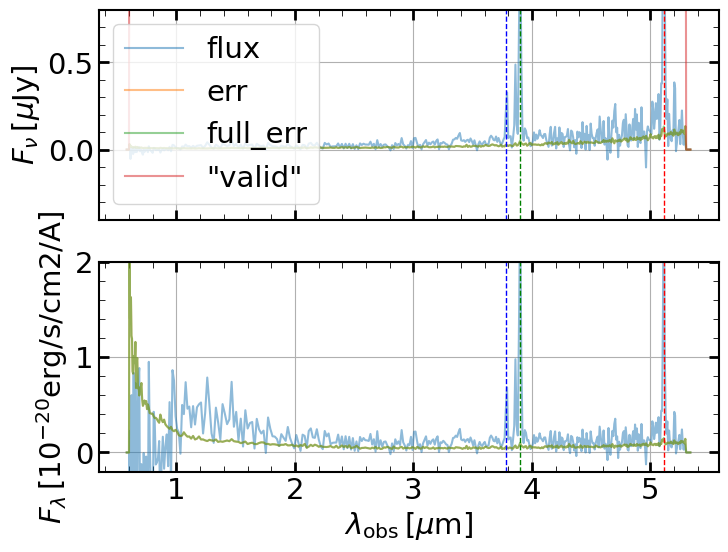

In [12]:
thisuid = 8219
src = np.array(uidlist == thisuid)
# grating = Grating[src][0]

urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
print(z)
# Open the files into 1D objects, directly from the web
sobj = {}
for url in urls:
    print(f'Read {url}')
    key = os.path.basename(url)
    sobj[key] = msaexp.spectrum.SpectrumSampler(url)

for j, k in enumerate(sobj):
    if 'prism' in k:
        break
# k = 'rubies-egs63-nod-v3_prism-clear_4233_47179.spec.fits'
print(k)

sp = sobj[k]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
ax = axes[0]
ymax = [8, 4, 8, 8]
for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c], alpha=0.5, label=c)
#ax.plot(sp.spec_wobs, sp.spec['err'], alpha=0.5, label='err')
#ax.plot(sp.spec_wobs, sp.spec['full_err'], alpha=0.5, label='full_err')
ax.axvline(x = 0.6568*(1+z), color='r', linestyle='--', lw = 1)
ax.axvline(x = 0.5007*(1+z), color='g', linestyle='--', lw = 1)
ax.axvline(x = 0.4861*(1+z), color='b', linestyle='--', lw = 1)
ax.set_ylim(-0.1*ymax[1], ymax[1]/5)
ax.plot(sp.spec_wobs, sp.valid*ymax[1]*0.8, alpha=0.5, label='"valid"')
ax.grid()
ax.legend()
ax.set_ylabel(r'$F_\nu\,[\mu\mathrm{Jy}]$')
ax = axes[1]
for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c]*sp.spec['to_flam'], alpha=0.5, label=c)
ax.set_ylim(-0.01*ymax[1]*5, ymax[1]*0.5)
ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm2/A}]$')
ax.grid()
ax.axvline(x = 0.6568*(1+z), color='r', linestyle='--', lw = 1)
ax.axvline(x = 0.5007*(1+z), color='g', linestyle='--', lw = 1)
ax.axvline(x = 0.4861*(1+z), color='b', linestyle='--', lw = 1)
# ax.set_xlim(0.6560*(1+z), 0.6575*(1+z))
ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')



In [13]:
uid

22015

6.7851
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
6.6202000000000005
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_53254.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_g395m-f290lp_4233_53254.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_53254.spec.fits
rubies-egs53-nod-v3_prism-clear_423

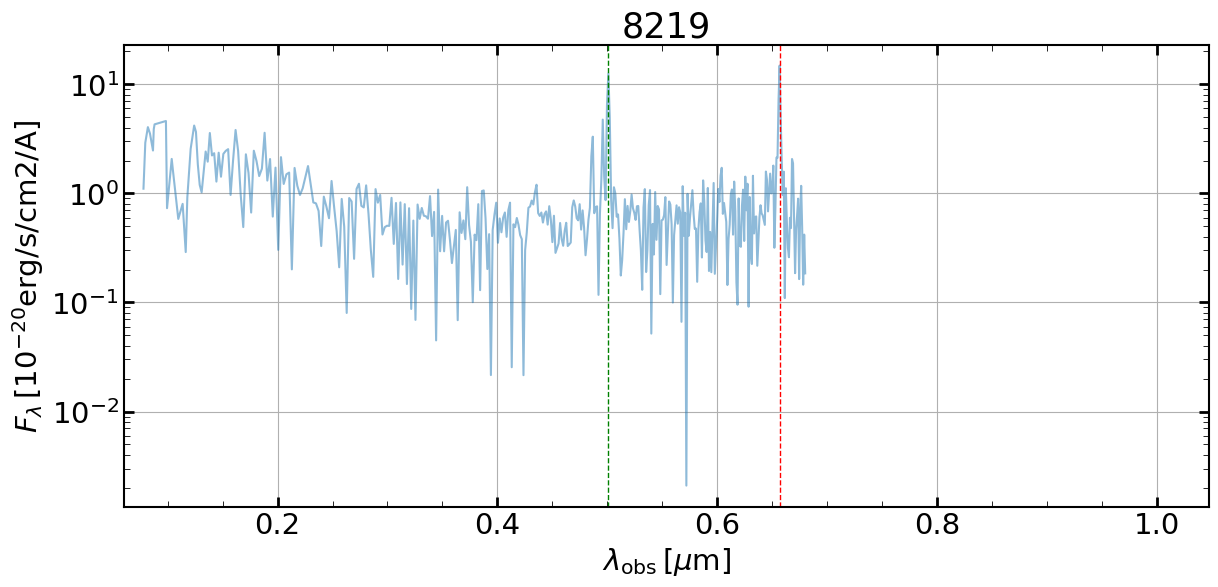

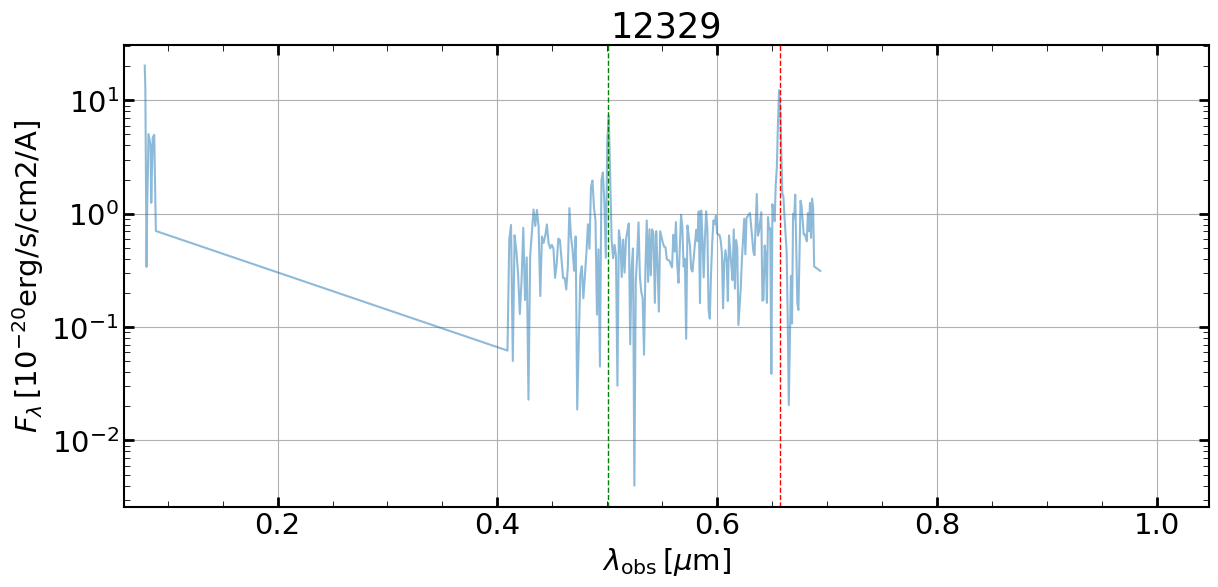

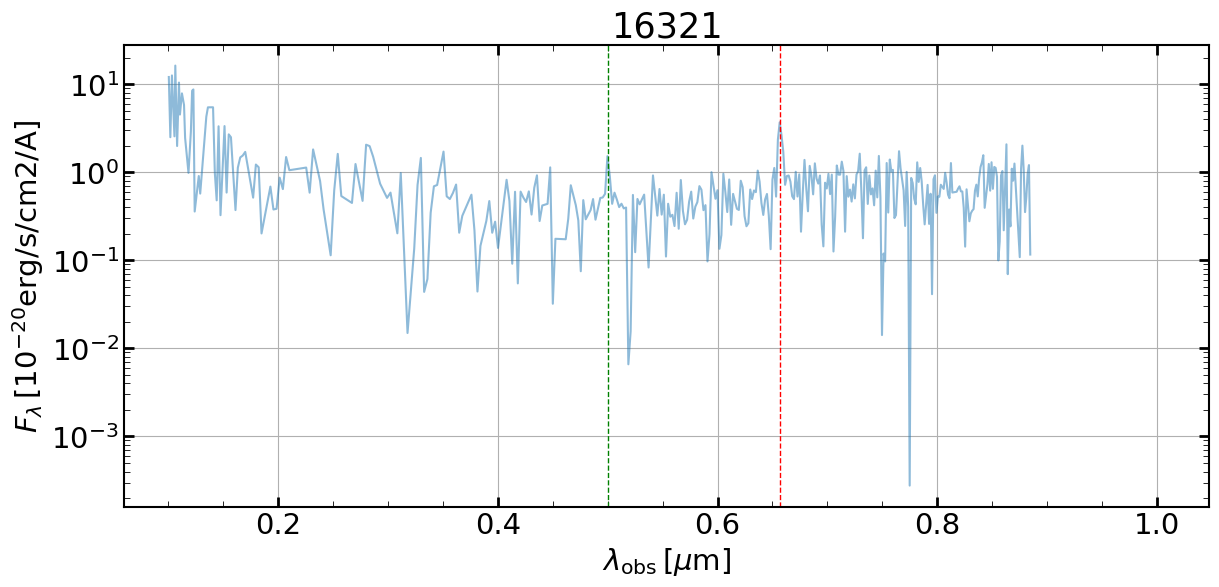

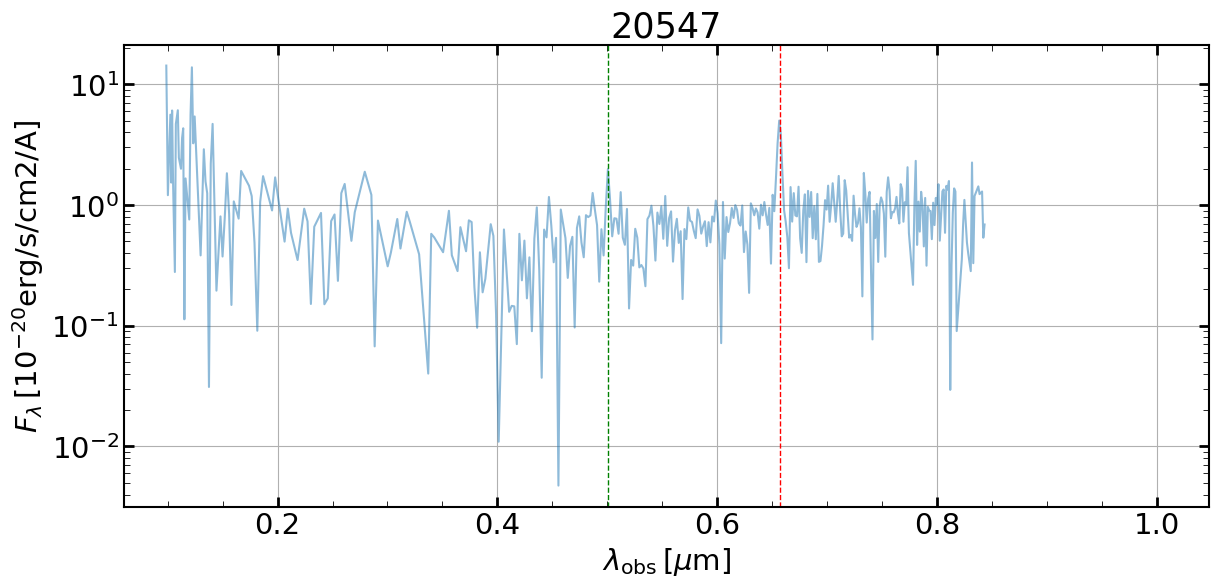

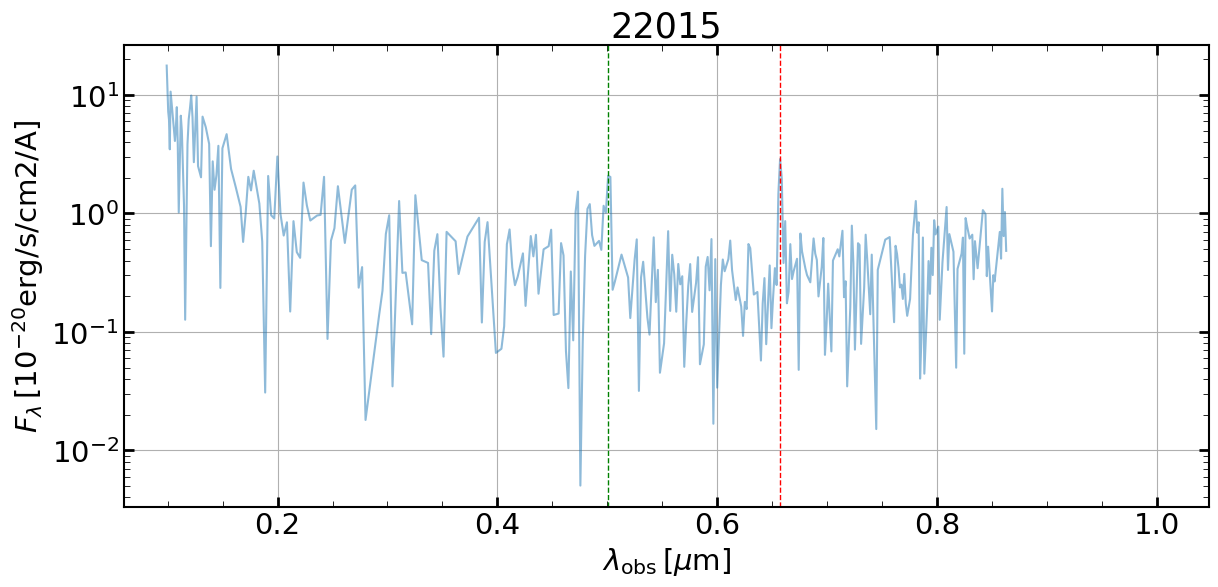

In [14]:
# uidlist = []


# for thisuid in broadlrdidlist:
# narrowuidlist = [8219, 12329, 15500, 16321, 20547, 22015]
# narrowuidlist  = np.array([ 12329,  22015,  8219, 20547])
for thisuid in narrowuidlist:
    # thisid = 407
    # if thisuid != 9073:
    #     continue
    src = np.array(uidlist  == thisuid)
    # grating = Grating[src][0]

    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        print(f'Read {url}')
        key = os.path.basename(url)
        sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        # if 'egs53-v3_prism' in k:
        if 'prism' in k:
            break
    if 'prism' not in k:
        continue

    # print(nrs[src])
    # uidlist.append(nrs[src]['uid'].tolist()[0])
    print(k)
    sp = sobj[k]

    fig, ax = plt.subplots(1,1,figsize=(14,6), sharex=True)
    wave = sp.spec_wobs/(1+z)
    flux = sp.spec['flux']
    err = sp.spec['err']
    convert = sp.spec['to_flam']
    mask = flux/err > 0
    wave, flux, err = wave[mask], flux[mask]*convert[mask], err[mask]*convert[mask]

    if('4233_7111' in k):
        mask = wave > 0.3
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]
    
    if('4233_37124' in k):
        mask = wave > 0.4
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]
    # for c in ['flux','err']:
    ax.plot(wave, flux/np.mean( flux), alpha=0.5, label='flux')
    # ax.set_ylim(-0.01, max(flux/np.mean( flux))/10)
    ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm2/A}]$')
    ax.grid()
    ax.axvline(x = 0.6568, color='r', linestyle='--', lw = 1)
    ax.axvline(x = 0.5007, color='g', linestyle='--', lw = 1)
    ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')
    ax.set_title(thisuid)
    ax.set_xlim(0.060048724, 1.0471756)
    ax.set_yscale('log')
    # ax.set_xscale('log')


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def compute_snr(flux, error):
    return flux / error

def select_snr_greater_than_1(flux, error):
    snr = compute_snr(flux, error)
    mask = snr > 1
    return mask


# Example usage:
# spectra = []
wavelist_br = []
fluxlist_br = []
errlist_br = []
# wavelist = []
# fluxlist = []
# errlist = []

# for j, k in enumerate(sobj):
#     if 'prism' in k:
#         sp = sobj[k]
#         spectra.append(sp)
for thisuid in broadlrdidlist:
# for thisuid in narrowuidlist:
    # thisid = 407
    src = np.array(uidlist == thisuid)
    # grating = Grating[src][0]

    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        print(f'Read {url}')
        key = os.path.basename(url)
        sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'prism' in k:
            break
    if 'prism' not in k:
        continue

    print(k)
    sp = sobj[k]
    # spectra.append(sp)
    wave = sp.spec_wobs/(1+z)
    flux = sp.spec['flux']
    err = sp.spec['err']
    convert = sp.spec['to_flam']
    mask = flux/err > 0
    wave, flux, err = wave[mask], flux[mask]*convert[mask], err[mask]*convert[mask]

    # if('4233_53254' in k):
    #     mask = wave > 0.4
    #     wave = wave[mask]
    #     flux = flux[mask]
    #     err = err[mask]
    
    if('4233_7111' in k):
        mask = wave > 0.3
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]
    
    if('4233_37124' in k):
        mask = wave > 0.4
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]

    # wavelist.append(wave)
    # fluxlist.append(flux)
    # errlist.append(err)
    wavelist_br.append(wave)
    fluxlist_br.append(flux)
    errlist_br.append(err)



5.92328
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-v3/gds-deep-v3_g140m-f070lp_1210_13704.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-v3/gds-deep-v3_g235m-f170lp_1210_13704.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-v3/gds-deep-v3_g395h-f290lp_1210_13704.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-v3/gds-deep-v3_g395m-f290lp_1210_13704.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-v3/gds-deep-v3_prism-clear_1210_13704.spec.fits
gds-deep-v3_prism-clear_1210_13704.spec.fits
4.13274
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v3/jades-gdn09-v3_g140m-f070lp_1181_73488.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v3/jades-gdn09-v3_g235m-f170lp_1181_73488.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/jades-gdn09-v3/jades-gdn09-v3_g395h-f290lp_1181_73488.spec.fits
Re

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def compute_snr(flux, error):
    return flux / error

def select_snr_greater_than_1(flux, error):
    snr = compute_snr(flux, error)
    mask = snr > 1
    return mask


# Example usage:
# spectra = []
# wavelist_br = []
# fluxlist_br = []
# errlist_br = []
wavelist = []
fluxlist = []
errlist = []

# for j, k in enumerate(sobj):
#     if 'prism' in k:
#         sp = sobj[k]
#         spectra.append(sp)
# for thisuid in broadlrdidlist:
for thisuid in narrowuidlist:
    # thisid = 407
    src = np.array(uidlist == thisuid)
    # grating = Grating[src][0]

    urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]
    z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])
    print(z)
    # Open the files into 1D objects, directly from the web
    sobj = {}
    for url in urls:
        print(f'Read {url}')
        key = os.path.basename(url)
        sobj[key] = msaexp.spectrum.SpectrumSampler(url)

    for j, k in enumerate(sobj):
        if 'prism' in k:
            break
    if 'prism' not in k:
        continue

    print(k)
    sp = sobj[k]
    # spectra.append(sp)
    wave = sp.spec_wobs/(1+z)
    flux = sp.spec['flux']
    err = sp.spec['err']
    convert = sp.spec['to_flam']
    mask = flux/err > 0
    wave, flux, err = wave[mask], flux[mask]*convert[mask], err[mask]*convert[mask]

    # if('4233_53254' in k):
    #     mask = wave > 0.4
    #     wave = wave[mask]
    #     flux = flux[mask]
    #     err = err[mask]
    
    if('4233_7111' in k):
        mask = wave > 0.3
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]
    
    if('4233_37124' in k):
        mask = wave > 0.4
        wave = wave[mask]
        flux = flux[mask]
        err = err[mask]

    wavelist.append(wave)
    fluxlist.append(flux)
    errlist.append(err)
    # wavelist_br.append(wave)
    # fluxlist_br.append(flux)
    # errlist_br.append(err)



6.7851
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-nod-v3/rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_g395m-f290lp_4233_927271.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs51-v3/rubies-egs51-v3_prism-clear_4233_927271.spec.fits
rubies-egs51-nod-v3_prism-clear_4233_927271.spec.fits
6.6202000000000005
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-nod-v3/rubies-egs53-nod-v3_prism-clear_4233_53254.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_g395m-f290lp_4233_53254.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs53-v3/rubies-egs53-v3_prism-clear_4233_53254.spec.fits
rubies-egs53-nod-v3_prism-clear_423

In [17]:

def scale_flux(wave, flux, target_wave=1.5):
    # 使用线性插值计算目标波长处的flux
    target_flux = np.interp(target_wave, wave, flux)
    return flux / target_flux

wave, flux, err, full_err = np.loadtxt('/Users/zijianzhang/Astro_Data/local_LRD_analog/JWST_spec/Malino23_13704_spectrum.txt').T
wave = wave/(1 + 5.9)*10000
wave1, flux1, err1, full_err1 = np.loadtxt('/Users/zijianzhang/Astro_Data/local_LRD_analog/JWST_spec/Wang24_40579_spectrum.txt').T
wave1 = wave1/(1 + 3.1034)*10000
flux1 = flux1 / wave1**2
flux_scaled = scale_flux(wave, flux, target_wave=5800)
flux1_scaled = scale_flux(wave1, flux1, target_wave=5800)


templatefile = '/Users/zijianzhang/Documents/xray_variability/Vanden2001.txt'
Vanden2001 = np.loadtxt(templatefile,skiprows=10)
Vanwave = Vanden2001[:,0]
Vanflux = Vanden2001[:,1]
Vanflux_scaled = scale_flux(Vanwave, Vanflux, target_wave=5800)


In [18]:
import scipy.interpolate as interp
import time

def calculate_snr(flux, error):
    """计算信噪比（SNR）"""
    return np.abs(flux) / error

import numpy as np
from scipy import interpolate as interp

# def stack_spectra(wavelist, fluxlist, errlist, snr_threshold=1, method='mean', scale=False, scale_to_3000=False):
#     """堆叠光谱，新增按3000Å附近的强度缩放和误差加权选项"""
    
#     # 先确定所有光谱的共同波长范围，使用最密集的波长网格
#     all_wavelengths = np.concatenate(wavelist)
#     common_wavelengths = np.unique(all_wavelengths)
    
#     # 插值所有光谱到共同的波长网格
#     stacked_flux = []
#     stacked_error = []
    
#     for i in range(len(wavelist)):
#         # 计算信噪比
#         snr = calculate_snr(fluxlist[i], errlist[i])
        
#         # 筛选出信噪比大于阈值的部分
#         mask = snr > snr_threshold
        
#         # 对流量和误差进行插值
#         interp_flux = interp.interp1d(wavelist[i][mask], fluxlist[i][mask], kind='linear', bounds_error=False, fill_value=np.nan)
#         interp_error = interp.interp1d(wavelist[i][mask], errlist[i][mask], kind='linear', bounds_error=False, fill_value=np.nan)
        
#         # 对每个光谱进行插值，放到统一的波长网格上
#         new_flux = interp_flux(common_wavelengths)
#         new_error = interp_error(common_wavelengths)
        
#         # 按3000Å附近的强度缩放（如果需要的话）
#         if scale_to_3000:
#             # 找到3000Å附近的波长索引
#             idx_3000 = np.argmin(np.abs(common_wavelengths - 3000))
#             # 计算3000Å附近的强度
#             scale_factor = np.nanmean(new_flux[idx_3000-10:idx_3000+10]) / np.nanmean(fluxlist[i])
#             new_flux *= scale_factor
#             new_error *= scale_factor
        
#         # 进行scale处理（如果需要的话）
#         if scale:
#             norm_factor = np.nanmean(new_flux / new_error)  # 计算均值时忽略NaN
#             new_flux /= norm_factor
#             new_error /= norm_factor
        
#         # 根据方法选择堆叠策略
#         if method == 'mean':
#             # 使用误差倒数作为权重进行加权平均
#             # weight = 1 / (new_error**2)
#             # stacked_flux.append(weight * new_flux)
#             # stacked_error.append(np.sqrt(1 / np.sum(weight)))  # 合成误差
#             weight = 1 / (new_error**2)
#             stacked_flux.append(new_flux)
#             stacked_error.append(np.sqrt(1 / np.sum(weight)))  # 合成误差
#         elif method == 'median':
#             stacked_flux.append(new_flux)
#             stacked_error.append(new_error)
    
#     # 最终堆叠（这里使用了加权平均）
#     if method == 'mean':
#         stacked_flux = np.nansum(stacked_flux, axis=0) / np.nansum(weight, axis=0)
#         stacked_error = np.sqrt(1 / np.nansum(1 / np.array(stacked_error)**2, axis=0))  # 使用加权误差
#     else:
#         stacked_flux = np.nanmedian(stacked_flux, axis=0)
#         stacked_error = np.nanmedian(stacked_error, axis=0)
    
#     return common_wavelengths, stacked_flux, stacked_error

def stack_spectra(wavelist, fluxlist, errlist, snr_threshold=1, method='mean', scale=False, scale_to_3000=False):
    """堆叠光谱"""
    # 先确定所有光谱的共同波长范围，使用最密集的波长网格
    all_wavelengths = np.concatenate(wavelist)
    common_wavelengths = np.unique(all_wavelengths)
    
    # 插值所有光谱到共同的波长网格
    stacked_flux = []
    stacked_error = []
    
    for i in range(len(wavelist)):
        # 计算信噪比
        snr = calculate_snr(fluxlist[i], errlist[i])
        
        # 筛选出信噪比大于阈值的部分
        mask = snr > snr_threshold
        if np.sum(mask) == 0:
            continue  # 如果这个光谱没有满足条件的点，就跳过

        # 对流量和误差进行插值
        interp_flux = interp.interp1d(wavelist[i][mask], fluxlist[i][mask], kind='linear', bounds_error=False, fill_value=np.nan)
        interp_error = interp.interp1d(wavelist[i][mask], errlist[i][mask], kind='linear', bounds_error=False, fill_value=np.nan)
        
        # 对每个光谱进行插值，放到统一的波长网格上
        new_flux = interp_flux(common_wavelengths)
        new_error = interp_error(common_wavelengths)
        
        if scale_to_3000:
            # 找到3000Å附近的波长索引
            idx_3000 = np.argmin(np.abs(common_wavelengths - 6000))
            # 计算3000Å附近的强度
            scale_factor = np.nanmean(fluxlist[i])/np.nanmean(new_flux[idx_3000-50:idx_3000+50]) 
            new_flux *= scale_factor
            new_error *= scale_factor

        # 进行scale处理（如果需要的话）
        if scale:
            norm_factor = np.nanmean(new_flux / new_error)  # 计算均值时忽略NaN
            new_flux /= norm_factor
            new_error /= norm_factor
        stacked_flux.append(new_flux)
        stacked_error.append(new_error)
        # 根据方法选择堆叠策略
    if method == 'mean':
        stacked_flux = np.nanmean(stacked_flux, axis=0)
        stacked_error = np.nanmean(stacked_error, axis=0)
    elif method == 'median':
        stacked_flux = np.nanmedian(stacked_flux, axis=0)
        stacked_error = np.nanmedian(stacked_error, axis=0)
        
    # 最终堆叠（这里使用了numpy的nanmean/nanmedian函数）
    return common_wavelengths, stacked_flux, stacked_error


def stack_spectra(wavelist, fluxlist, errlist, snr_threshold=1, method='median', scale=False, scale_to_3000=False, n_bootstrap=1000):
    """堆叠光谱（支持mean/median堆叠，误差通过bootstrap估计）"""
    # 合并所有波长，建立统一网格
    all_wavelengths = np.concatenate(wavelist)
    max_wave = max(all_wavelengths)
    min_wave = min(all_wavelengths)
    common_wavelengths = np.linspace(min_wave, max_wave, int((max_wave - min_wave)*1e4) )#np.unique(all_wavelengths)
    
    interpolated_fluxes = []

    for i in range(len(wavelist)):
        # 计算信噪比
        snr = calculate_snr(fluxlist[i], errlist[i])
        mask = snr > snr_threshold
        
        if np.sum(mask) == 0:
            continue  # 如果这个光谱没有满足条件的点，就跳过

        # 插值到统一波长
        interp_flux = interp.interp1d(wavelist[i][mask], fluxlist[i][mask], kind='linear', bounds_error=False, fill_value=np.nan)
        new_flux = interp_flux(common_wavelengths)
        
        if scale_to_3000:
            idx_3000 = np.argmin(np.abs(common_wavelengths - 6000))
            scale_factor = np.nanmean(fluxlist[i]) / np.nanmean(new_flux[idx_3000-20:idx_3000+20])
            new_flux *= scale_factor

        if scale:
            norm_factor = np.nanmean(new_flux)
            new_flux /= norm_factor
        
        interpolated_fluxes.append(new_flux)

    interpolated_fluxes = np.array(interpolated_fluxes)  # shape: (N_spectra, N_wavelengths)

    # 根据method选择stack方式
    if method == 'mean':
        stacked_flux = np.nanmean(interpolated_fluxes, axis=0)
    elif method == 'median':
        stacked_flux = np.nanmedian(interpolated_fluxes, axis=0)
    else:
        raise ValueError(f"Invalid method '{method}'. Choose 'mean' or 'median'.")

    # Bootstrap计算误差
    bootstrap_fluxes = []
    n_spectra = interpolated_fluxes.shape[0]

    for _ in range(n_bootstrap):
        resample_indices = np.random.choice(n_spectra, n_spectra, replace=True)
        resample_fluxes = interpolated_fluxes[resample_indices, :]
        if method == 'mean':
            resample_stat = np.nanmean(resample_fluxes, axis=0)
        else:  # median
            resample_stat = np.nanmedian(resample_fluxes, axis=0)
        bootstrap_fluxes.append(resample_stat)

    bootstrap_fluxes = np.array(bootstrap_fluxes)  # shape: (n_bootstrap, N_wavelengths)

    # 每个波长点bootstrap的标准差作为误差
    stacked_error = np.nanstd(bootstrap_fluxes, axis=0)

    return common_wavelengths, stacked_flux, stacked_error
# 使用示例
scale_to_3000 = True
method = 'median'
scale = False

# a random mask to select half of the item from wavelist
# Create a random mask that selects half of the items
mask = np.random.rand(len(wavelist)) < 0.5
# Optionally, if you want exactly half:
N = len(wavelist_br)

# selected_indices = np.random.choice(N, size=N//2, replace=False)

np.random.seed(int(time.time()))  # 用当前时间作为种子
selected_indices = np.random.choice(N, size=N//2, replace=False)
# Select the corresponding spectra
wavelist_selected = [wavelist_br[i] for i in selected_indices]
fluxlist_selected = [fluxlist_br[i] for i in selected_indices]
errlist_selected =   [errlist_br[i] for i in selected_indices]

# Now pass to your stacking function
common_wavelengths_na, stacked_flux_na, stacked_error_na = stack_spectra(
    wavelist, fluxlist, errlist,
    snr_threshold=1, method=method, scale=scale, scale_to_3000=scale_to_3000
)
common_wavelengths_br2, stacked_flux_br2, stacked_error_br2= stack_spectra( wavelist_selected, fluxlist_selected, errlist_selected, snr_threshold=1, method=method, scale=scale , scale_to_3000=scale_to_3000)
common_wavelengths_br, stacked_flux_br, stacked_error_br = stack_spectra(wavelist_br, fluxlist_br, errlist_br, snr_threshold=1, method=method, scale=scale , scale_to_3000=scale_to_3000)

stacked_flux_br = stacked_flux_br/2
stacked_error_br = stacked_error_br/2
gap = 4
idx_3000 = np.argmin(np.abs(common_wavelengths_na - 0.6))
scale_factor1 = np.nanmean(stacked_flux_na[idx_3000-gap:idx_3000+gap]) 
idx_3000 = np.argmin(np.abs(common_wavelengths_br - 0.6))
scale_factor2 = np.nanmean(stacked_flux_br[idx_3000-gap:idx_3000+gap]) 
idx_3000 = np.argmin(np.abs(common_wavelengths_br2 - 0.6))
scale_factor3 = np.nanmean(stacked_flux_br2[idx_3000-gap:idx_3000+gap]) 

scale_factor = scale_factor2/scale_factor1
scale_factor_ = scale_factor2/scale_factor3

In [19]:
# common_wavelengths_br, stacked_flux_br, stacked_error_br = stack_spectra(wavelist_br, fluxlist_br, errlist_br, snr_threshold=1, method='median', scale=False)
fig, ax = plt.subplots(1,1,figsize=(14,8), sharex=True)




ax.plot(common_wavelengths_na*1e4, stacked_flux_na*scale_factor*common_wavelengths_na, label='Narrow-line LRDs stacked spectrum', lw = 1)
ax.fill_between(common_wavelengths_na*1e4, (stacked_flux_na - stacked_error_na)*scale_factor*common_wavelengths_na, (stacked_flux_na + stacked_error_na)*scale_factor*common_wavelengths_na, alpha=0.5)


ax.plot(common_wavelengths_br*1e4, stacked_flux_br*common_wavelengths_br, label='Broad-line LRDs stacked spectrum', lw = 1)
ax.fill_between(common_wavelengths_br*1e4, (stacked_flux_br - stacked_error_br)*common_wavelengths_br, (stacked_flux_br + stacked_error_br)*common_wavelengths_br, alpha=0.5)

# ax.plot(common_wavelengths_br2*1e4, stacked_flux_br2*scale_factor_, label='broad-line LRDs Stacked Spectrum (random 50%)')
# ax.fill_between(common_wavelengths_br2*1e4, (stacked_flux_br2 - stacked_error_br2)*scale_factor_, (stacked_flux_br2 + stacked_error_br2)*scale_factor_, alpha=0.5)



ax.set_xlabel(r'Rest Wavelength ($\rm \AA$)')
ax.set_ylabel(r'$\lamdba f_{\lambda}$ (arbitrary units)')
ax.set_yscale('log')
# ax.set_yscale('log')
# ax.set_xscale('log')

def mark_emission_lines(ax,z):
    lines = {
    'Lyα': 1216,        # Lyα
    # 'N V': 1240,         # N V
    'Si IV, O IV]': 1396,       # Si II
    'C IV': 1549.06,
    'C III]': 1908.73,
    'Mg II': 2799,       # Mg II
    '[Ne V] ': 3426.84,         # NeV  3427
    '[O II]': 3728.28,      # [OII] 双峰 (合并值)
    '[Ne III]': 3869,      # NeIII
    # 'NeIII39': 3968,      # NeIII
    # 'Hε': 3970,   # Hε
    'Hδ': 4102,         # Hδ
    '[O III]+Hγ': 4340,         # Hγ
    # 'HeII': 4686,       # HeII
    '[O III]': 5007,     # [OIII]
    'Hβ': 4861,         # Hβ
    'He I ': 5876,


    'Hα': 6563,         # Hα
    'He I': 7065.196,
    'O I': 8435,
    # 'NII': 6583,        # [NII]
    # 'SII': 6716,        # [SII]
    # 'SII': 6731,        # [SII]
    'Pa-9': 9229.014, 
    'Pa-Ɛ, [S III]': 9545.969, 
    'Paδ': 10049.368,        # Paschen-alpha (Paα)
    # 'Paβ': 

    }
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        # if obs_wave < 0.7 or obs_wave > 5.0:
        #     continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1.45, f'{line}', rotation=90, verticalalignment='bottom',fontsize=14)

mark_emission_lines(ax,0)


# ax.plot(wave, flux_scaled/10, label='Malino23_13704')
ax.plot(wave1[wave1 >2000], flux1_scaled[wave1 > 2000]/6*wave1[wave1 >2000]/1e4, label='Wang+2024 LRD',  alpha =  1, ls = "--")
ax.plot(Vanwave, Vanflux_scaled/6*Vanwave/1e4, label='Vanden+2001 quasar template', alpha = 0.6, ls = ':')

ax.legend(fontsize=15, loc = 'lower right')
# plt.yscale('log')


ax.set_xlim(0.060048724e4, 1.0471756e4)
ax.set_ylim(0.015, 4)
# enlarge tick


# ax.set_xlim(0.060048724e4, 0.2471756e4)
# ax.grid()
plt.savefig('../Figure/scale_mean_stacked_spectra.pdf', dpi=300, bbox_inches='tight')
plt.show()

ValueError: 
\lamdba f_{\lambda}
^
ParseFatalException: Unknown symbol: \lamdba, found '\'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x35bc72040> (for post_execute):


ValueError: 
\lamdba f_{\lambda}
^
ParseFatalException: Unknown symbol: \lamdba, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\lamdba f_{\lambda}
^
ParseFatalException: Unknown symbol: \lamdba, found '\'  (at char 0), (line:1, col:1)

<Figure size 1400x800 with 1 Axes>

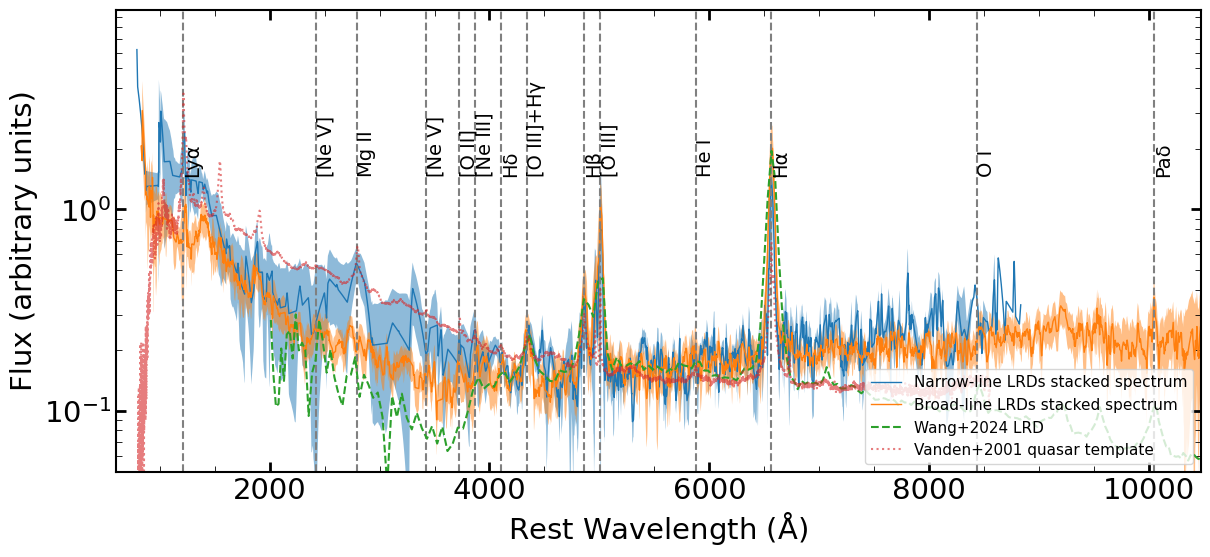

In [ ]:
# common_wavelengths_br, stacked_flux_br, stacked_error_br = stack_spectra(wavelist_br, fluxlist_br, errlist_br, snr_threshold=1, method='median', scale=False)
fig, ax = plt.subplots(1,1,figsize=(14,6), sharex=True)




ax.plot(common_wavelengths_na*1e4, stacked_flux_na*scale_factor, label='Narrow-line LRDs stacked spectrum', lw = 1)
ax.fill_between(common_wavelengths_na*1e4, (stacked_flux_na - stacked_error_na)*scale_factor, (stacked_flux_na + stacked_error_na)*scale_factor, alpha=0.5)


ax.plot(common_wavelengths_br*1e4, stacked_flux_br, label='Broad-line LRDs stacked spectrum', lw = 1)
ax.fill_between(common_wavelengths_br*1e4, (stacked_flux_br - stacked_error_br), (stacked_flux_br + stacked_error_br), alpha=0.5)

# ax.plot(common_wavelengths_br2*1e4, stacked_flux_br2*scale_factor_, label='broad-line LRDs Stacked Spectrum (random 50%)')
# ax.fill_between(common_wavelengths_br2*1e4, (stacked_flux_br2 - stacked_error_br2)*scale_factor_, (stacked_flux_br2 + stacked_error_br2)*scale_factor_, alpha=0.5)



ax.set_xlabel(r'Rest Wavelength ($\rm \AA$)')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_yscale('log')
# ax.set_yscale('log')
# ax.set_xscale('log')

def mark_emission_lines(ax,z):
    lines = {
    'Lyα': 1216,        # Lyα
    # 'N V': 1240,         # N V
    # 'Si II': 1260,       # Si II
    '[Ne V]': 2423,         # NeV  2422,24
    'Mg II': 2799,       # Mg II
    '[Ne V] ': 3426,         # NeV  3427
    '[O II]': 3727,      # [OII] 双峰 (合并值)
    '[Ne III]': 3869,      # NeIII
    # 'NeIII39': 3968,      # NeIII
    # 'Hε': 3970,   # Hε
    'Hδ': 4102,         # Hδ
    '[O III]+Hγ': 4340,         # Hγ
    # 'HeII': 4686,       # HeII
    '[O III]': 5007,     # [OIII]
    'Hβ': 4861,         # Hβ
    'He I': 5876,


    'Hα': 6563,         # Hα
    'O I': 8435,
    # 'NII': 6583,        # [NII]
    # 'SII': 6716,        # [SII]
    # 'SII': 6731,        # [SII]
    'Paδ': 10050,        # Paschen-alpha (Paα)
    # 'Paβ': 

    }
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        # if obs_wave < 0.7 or obs_wave > 5.0:
        #     continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1.45, f'{line}', rotation=90, verticalalignment='bottom',fontsize=14)

mark_emission_lines(ax,0)


# ax.plot(wave, flux_scaled/10, label='Malino23_13704')
ax.plot(wave1[wave1 >2000], flux1_scaled[wave1 > 2000]/6, label='Wang+2024 LRD',  alpha =  1, ls = "--")
ax.plot(Vanwave, Vanflux_scaled/7, label='Vanden+2001 quasar template', alpha = 0.6, ls = ':')

ax.legend(fontsize=11, loc = 'lower right')
# plt.yscale('log')


ax.set_xlim(0.060048724e4, 1.0471756e4)
ax.set_ylim(0.05, )
# enlarge tick


# ax.set_xlim(0.060048724e4, 0.2471756e4)
# ax.grid()
plt.savefig('../Figure/scale_mean_stacked_spectra.pdf', dpi=300, bbox_inches='tight')
plt.show()

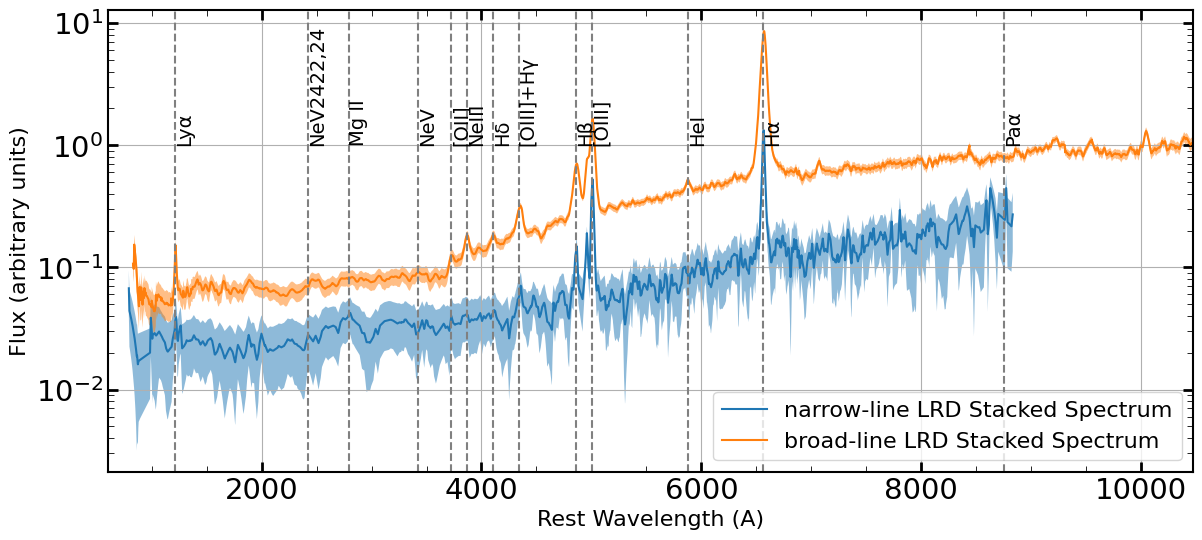

In [187]:
# 使用示例
common_wavelengths_na, stacked_flux_na, stacked_error_na = stack_spectra(wavelist, fluxlist, errlist, snr_threshold=1, method='median', scale=False)
common_wavelengths_br, stacked_flux_br, stacked_error_br = stack_spectra(wavelist_br, fluxlist_br, errlist_br, snr_threshold=1, method='median', scale=False)

fig, ax = plt.subplots(1,1,figsize=(14,6), sharex=True)
ax.plot(common_wavelengths_na*1e4, stacked_flux_na, label='narrow-line LRD Stacked Spectrum')
ax.fill_between(common_wavelengths_na*1e4, stacked_flux_na - stacked_error_na, stacked_flux_na + stacked_error_na, alpha=0.5)

stacked_flux_br = stacked_flux_br*2
ax.plot(common_wavelengths_br*1e4, stacked_flux_br, label='broad-line LRD Stacked Spectrum')
ax.fill_between(common_wavelengths_br*1e4, stacked_flux_br - stacked_error_br, stacked_flux_br + stacked_error_br, alpha=0.5)


ax.set_xlabel('Rest Wavelength (A)', fontsize=16)
ax.set_ylabel('Flux (arbitrary units)', fontsize=16)
ax.set_yscale('log')
# ax.set_xscale('log')

def mark_emission_lines(ax,z):
    lines = {
    'Lyα': 1216,        # Lyα
    # 'N V': 1240,         # N V
    # 'Si II': 1260,       # Si II
    'NeV2422,24': 2423,         # NeV
    'Mg II': 2799,       # Mg II
    'NeV': 3426,         # NeV
    '[OII]': 3727,      # [OII] 双峰 (合并值)
    'NeIII': 3869,      # NeIII
    # 'NeIII39': 3968,      # NeIII
    # 'Hε': 3970,   # Hε
    'Hδ': 4102,         # Hδ
    '[OIII]+Hγ': 4340,         # Hγ
    # 'HeII': 4686,       # HeII
    '[OIII]': 5007,     # [OIII]
    'Hβ': 4861,         # Hβ
    'HeI': 5876,


    'Hα': 6563,         # Hα
    # 'NII': 6583,        # [NII]
    # 'SII': 6716,        # [SII]
    # 'SII': 6731,        # [SII]
    'Paα': 8756,        # Paschen-alpha (Paα)

    }
    for line, rest_wave in lines.items():
        # for z in [5.5, 7.5]:  # 以两个红移值为例
        obs_wave = rest_wave * (1 + z)
        # if obs_wave < 0.7 or obs_wave > 5.0:
        #     continue
        ax.axvline(obs_wave, linestyle='--', color='grey')
        ax.text(obs_wave, 1, f'{line}', rotation=90, verticalalignment='bottom',fontsize=14)

mark_emission_lines(ax,0)
ax.legend(fontsize=16)

ax.set_xlim(0.060048724e4, 1.0471756e4)
# ax.set_ylim(-0.01, 0.2)
# ax.set_xlim(0.060048724e4, 0.2471756e4)
ax.grid()
plt.show()

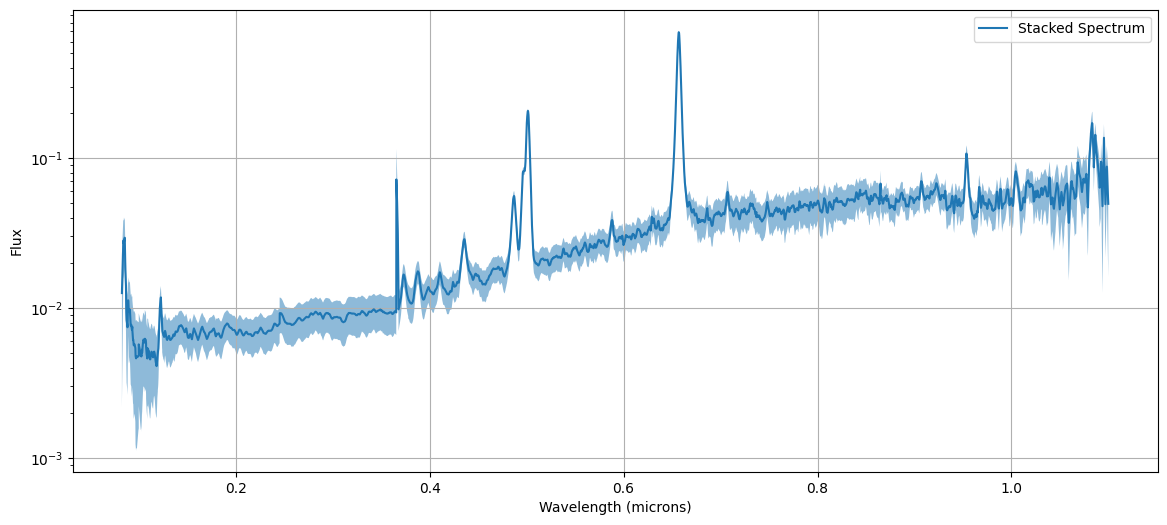

In [110]:
# 使用示例


fig, ax = plt.subplots(1,1,figsize=(14,6), sharex=True)
ax.plot(common_wavelengths, stacked_flux, label='Stacked Spectrum')
ax.fill_between(common_wavelengths, stacked_flux - stacked_error, stacked_flux + stacked_error, alpha=0.5)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Flux')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.grid()
plt.show()